In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [39]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and958_reset.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


Load config

In [40]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [41]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [42]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [9]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec

In [ ]:
qfreqs = []
qubit0 = 1
for qubit1 in range(1):
# for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 15
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2,
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        pulseB=True, # Whether to apply pi pulse to qubit B
        length=1, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        pulse_type='gauss',
        qubits=[qubit0, qubit1],
    )
    
    # qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4135.422739830673, HWHM 0.14119018456768925
Found peak in I at [MHz] 4135.406239888299, HWHM -0.1852927463767843
Found peak in Q at [MHz] 4135.4271948193855, HWHM -0.13263255967128787


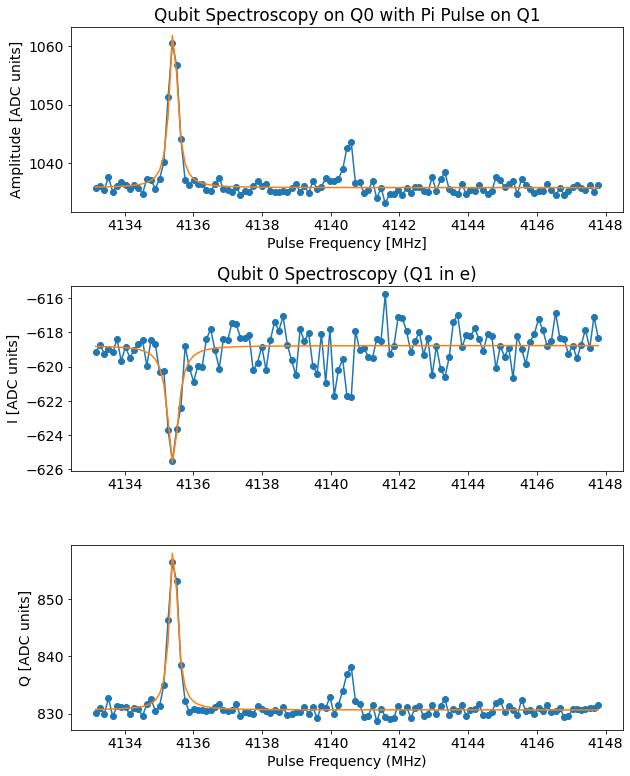

Fit Q0 frequency with ZZ shift [MHz]: 4135.422739830673
Q0 shift due to Q1 in e [MHz]: -5.111003908981729


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4140.400361458295, HWHM -0.1122147232770292
Found peak in I at [MHz] 4140.397724106943, HWHM -0.11332125175912158
Found peak in Q at [MHz] 4140.40092043002, HWHM 0.11206819860377168


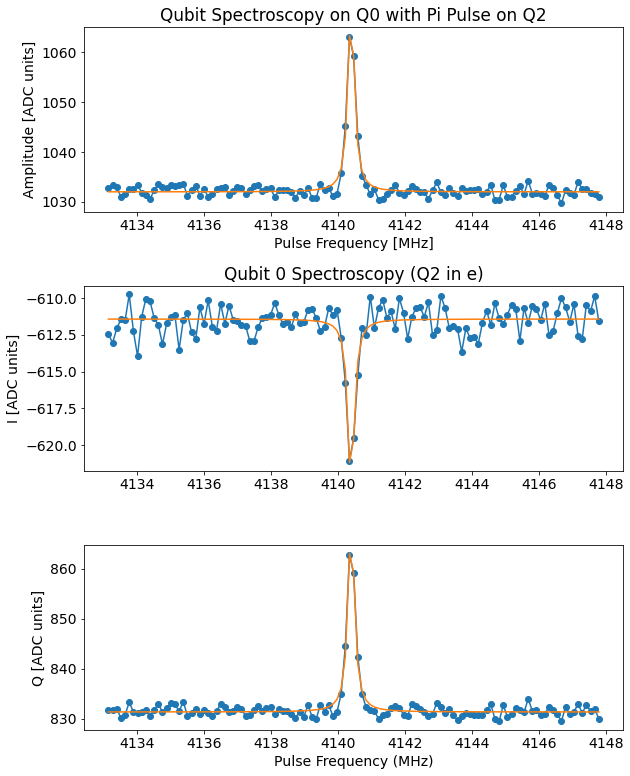

Fit Q0 frequency with ZZ shift [MHz]: 4140.40092043002
Q0 shift due to Q2 in e [MHz]: -0.13282330963465938


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4140.0296612358, HWHM 0.14023482501796133
Found peak in I at [MHz] 4140.037941250414, HWHM 0.13572073459679454
Found peak in Q at [MHz] 4140.0273523730375, HWHM 0.14194284632085202


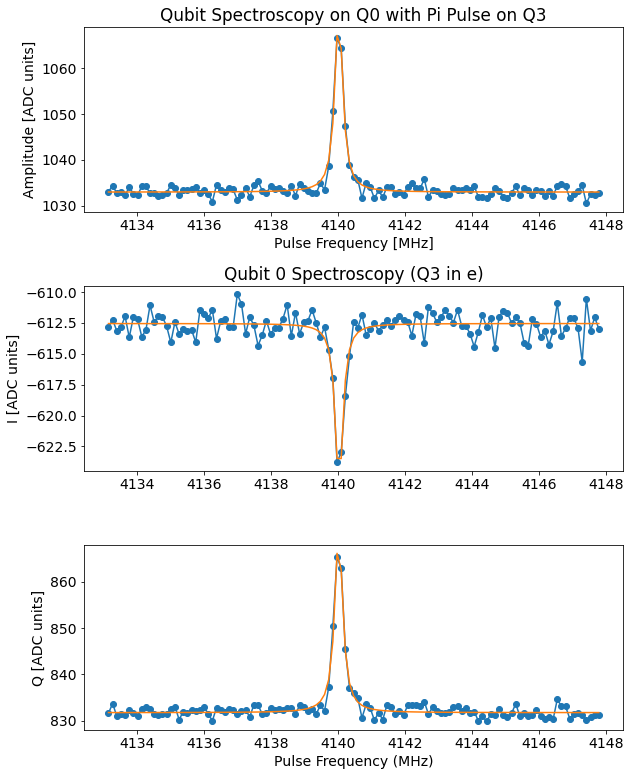

Fit Q0 frequency with ZZ shift [MHz]: 4140.0296612358
Q0 shift due to Q3 in e [MHz]: -0.5040825038549883


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3458.631922196038, HWHM -0.13013505398496755
Found peak in I at [MHz] 3458.639247353566, HWHM -0.057185021815921624
Found peak in Q at [MHz] 3458.6313500492383, HWHM 0.14269483111676526


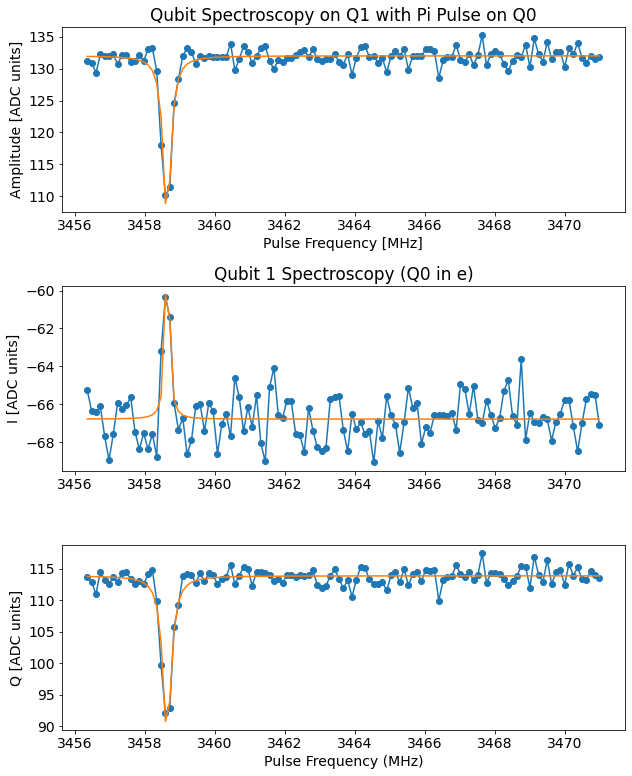

Fit Q1 frequency with ZZ shift [MHz]: 3458.6313500492383
Q1 shift due to Q0 in e [MHz]: -5.097023724204519


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3462.6641577996447, HWHM 0.15398912293011507
Found peak in I at [MHz] 3462.6687710853375, HWHM -0.13421700739388165
Found peak in Q at [MHz] 3462.6633991208782, HWHM 0.15698125254376877


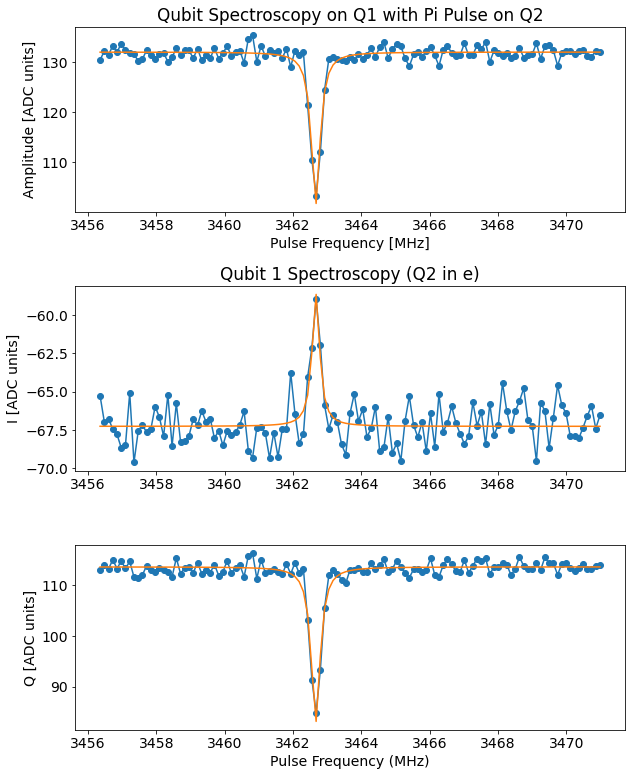

Fit Q1 frequency with ZZ shift [MHz]: 3462.6633991208782
Q1 shift due to Q2 in e [MHz]: -1.064974652564615


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3462.4891125696327, HWHM -0.13936452176942798
Found peak in I at [MHz] 3462.4924535285963, HWHM -0.09040203977372865
Found peak in Q at [MHz] 3462.489526023817, HWHM 0.14526938718433247


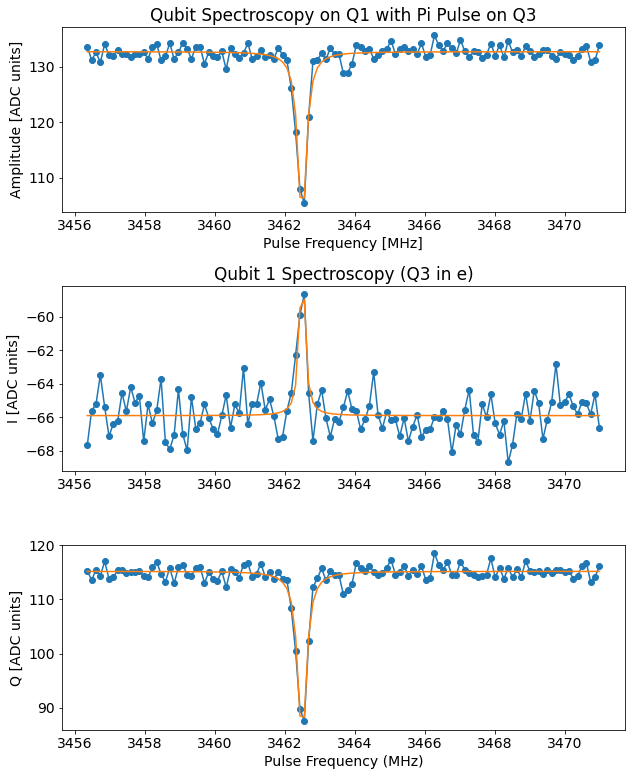

Fit Q1 frequency with ZZ shift [MHz]: 3462.489526023817
Q1 shift due to Q3 in e [MHz]: -1.2388477496260748


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4799.968422743403, HWHM 0.12178058483379244
Found peak in I at [MHz] 4799.96817362578, HWHM 0.1252354843601952
Found peak in Q at [MHz] 4799.970363562238, HWHM 0.10262876009185709


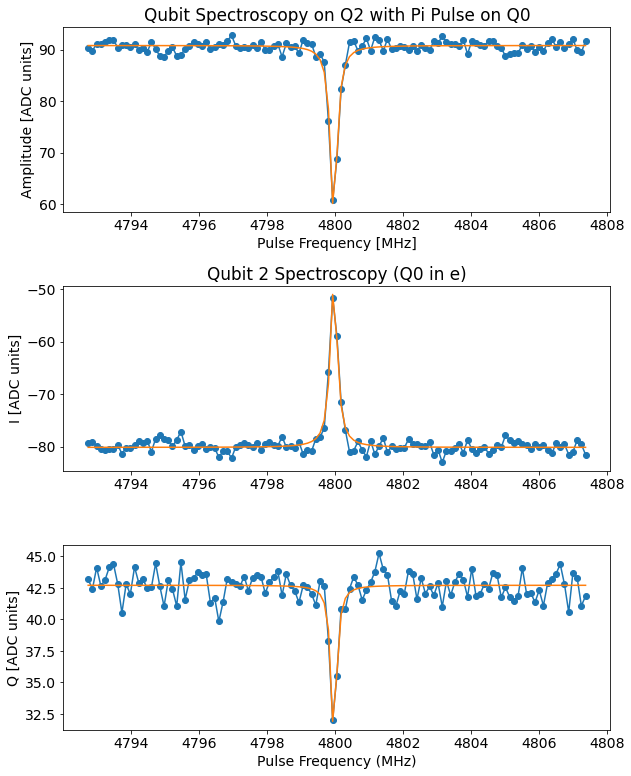

Fit Q2 frequency with ZZ shift [MHz]: 4799.968422743403
Q2 shift due to Q0 in e [MHz]: -0.15154836343481293


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4799.008460642373, HWHM -0.11131454759856649
Found peak in I at [MHz] 4799.012092652004, HWHM -0.125901608810023
Found peak in Q at [MHz] 4800.087541295708, HWHM 0.07670463524091689


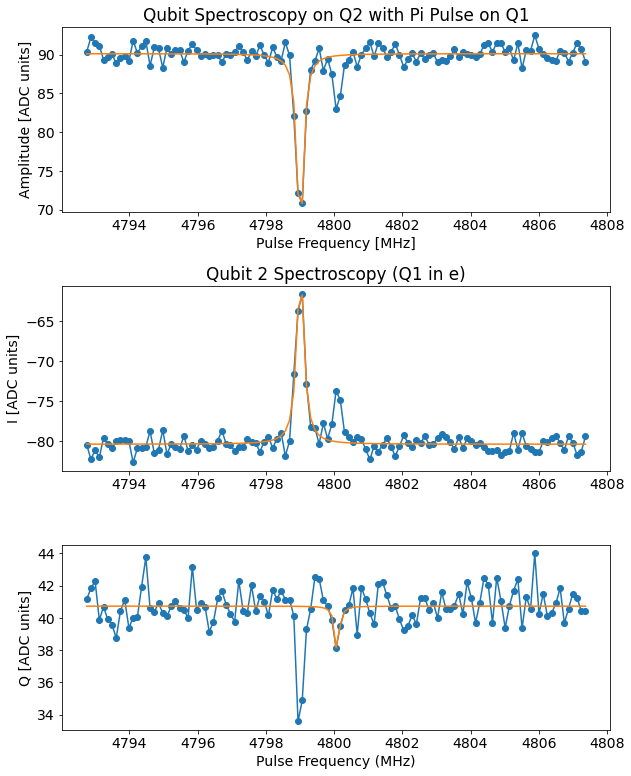

Fit Q2 frequency with ZZ shift [MHz]: 4799.012092652004
Q2 shift due to Q1 in e [MHz]: -1.1078784548335534


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4799.599840936048, HWHM 0.14327272164582613
Found peak in I at [MHz] 4799.598999690798, HWHM 0.1376513974895789
Found peak in Q at [MHz] 4799.611466508115, HWHM 0.17591604429292618


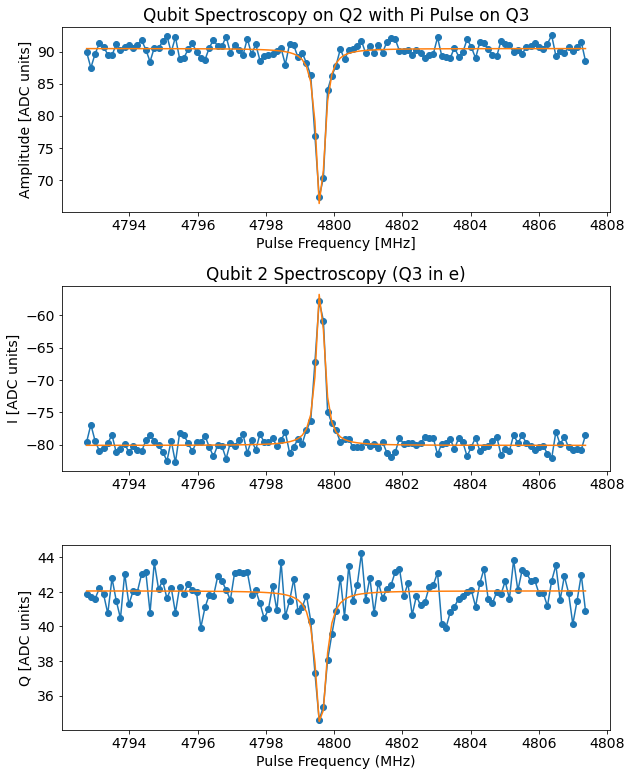

Fit Q2 frequency with ZZ shift [MHz]: 4799.599840936048
Q2 shift due to Q3 in e [MHz]: -0.5201301707893435


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4414.742270925042, HWHM 0.13904179657121193
Found peak in I at [MHz] 4414.745581772338, HWHM 0.13753468451476544
Found peak in Q at [MHz] 4414.692405432709, HWHM 0.11979686955996757


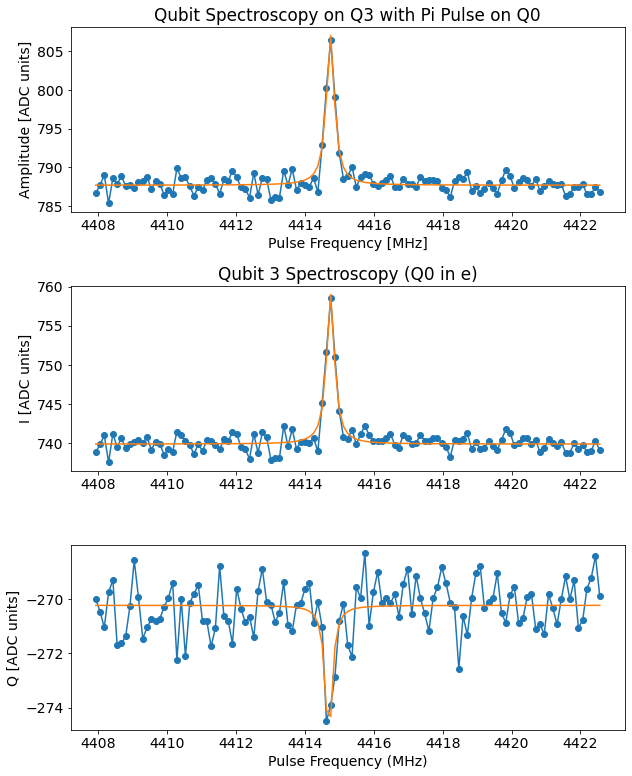

Fit Q3 frequency with ZZ shift [MHz]: 4414.745581772338
Q3 shift due to Q0 in e [MHz]: -0.5622014704358662


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4413.963277645748, HWHM 0.14844591766425516
Found peak in I at [MHz] 4413.967818682081, HWHM 0.1520544728497194
Found peak in Q at [MHz] 4413.936058298873, HWHM -0.10920253663679401


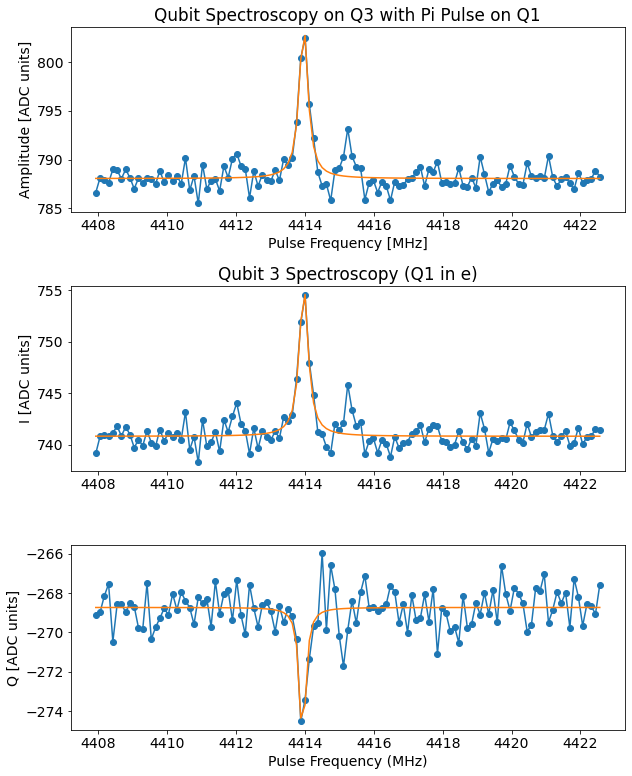

Fit Q3 frequency with ZZ shift [MHz]: 4413.963277645748
Q3 shift due to Q1 in e [MHz]: -1.3445055970250905


  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4414.713733097244, HWHM 0.13145129163891628
Found peak in I at [MHz] 4414.713100006691, HWHM -0.13623110022822071
Found peak in Q at [MHz] 4414.714481129461, HWHM -0.0968250251783504


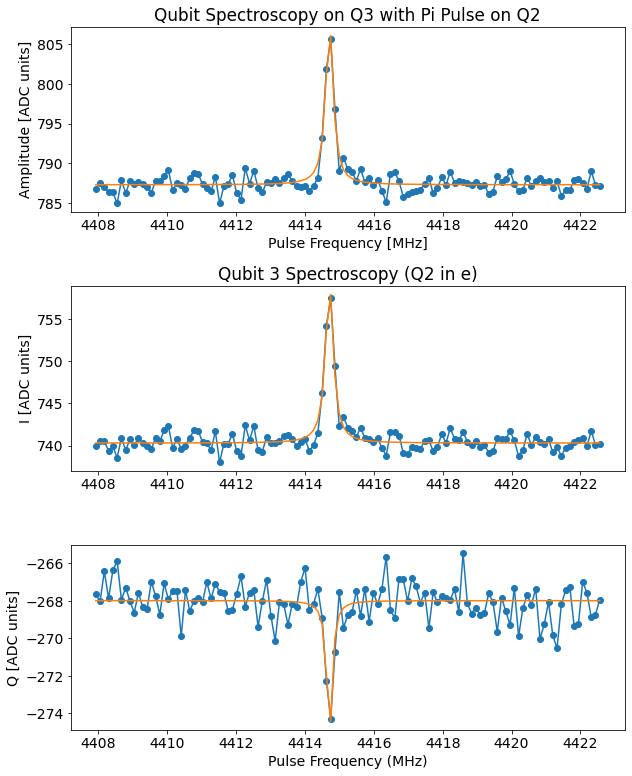

Fit Q3 frequency with ZZ shift [MHz]: 4414.713100006691
Q3 shift due to Q2 in e [MHz]: -0.5946832360823464
[[ 0.         -5.11100391 -0.13282331 -0.5040825 ]
 [-5.09702372  0.         -1.06497465 -1.23884775]
 [-0.15154836 -1.10787845  0.         -0.52013017]
 [-0.56220147 -1.3445056  -0.59468324  0.        ]]


In [35]:
for qubit0 in range(4): # qubit to measure
    # for qubit1 in range(1): # qubit to pulse to e
    for qubit1 in range(4): # qubit to pulse to e
        # if qubit0 != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 15
        npts = 121
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=20, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=1, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/100), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [36]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.111003908981729, -0.13282330963465938, -0.5040825038549883, -5.097023724204519, 0.0, -1.064974652564615, -1.2388477496260748, -0.15154836343481293, -1.1078784548335534, 0.0, -0.5201301707893435, -0.5622014704358662, -1.3445055970250905, -0.5946832360823464, 0.0]


In [15]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3458.7059861124717, 3463.808810074577, 3462.8644013091084, 3462.7481140969167]


# Get couplings by optimization

In [16]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [17]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [18]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)

In [22]:
x0 = np.array([100, 100, 100, 10, 10, 10])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds , method='L-BFGS-B')

qubit freqs [4140.53374374 3463.72837377 4800.11997111 4415.30778324]
alphas [-225.77672228 -100.20552422 -189.32224998 -172.14511866]
Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [54.38663964 52.60236201 41.1249601   6.26475719  2.73059709  6.00700312]


In [24]:
print(f'Success: {result.success}')
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {1e3*result.x}')
gs_opt = result.x

Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [54.38663964 52.60236201 41.1249601   6.26475719  2.73059709  6.00700312]


In [23]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.11459456 -0.18282364 -0.49816423]
 [-5.10282396  0.         -0.94440877 -1.06069598]
 [-0.18631446 -0.95319033  0.         -0.48414733]
 [-0.50653941 -1.09093474 -0.40800301  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -5.10870816 -0.18456904 -0.50235095]
 [-5.10870816  0.         -0.94880018 -1.07581543]
 [-0.18456904 -0.94880018  0.         -0.44607425]
 [-0.50235095 -1.07581543 -0.44607425  0.        ]]
Optimization error: 0.0035051665551074844


# ZZ shifted pi pulse calibrations for Q1

In [44]:
save_data = False
saved_files = []

In [45]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 2 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.393724023982832
Pi length from avgi data [us]: 0.019820114038854027
	Pi/2 length from avgi data [us]: 0.009910057019427014

Decay from avgq [us] 0.436705214163729
Pi length from avgq data [us]: 0.019356357230870317
Pi/2 length from avgq data [us]: 0.009678178615435159


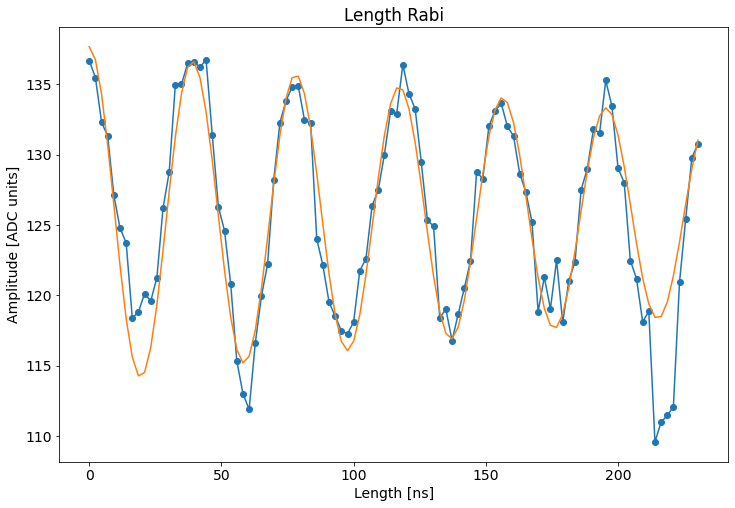

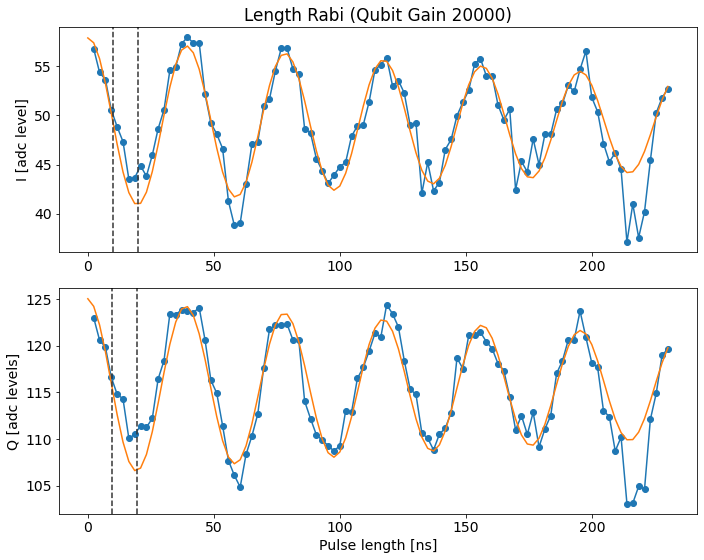

Will use sigma 0.01754407929194406 for amplitude rabi
-------- Amp rabi --------
1551645118


  0%|          | 0/30 [00:00<?, ?it/s]

17302
Attempted to init fitparam 4 to 45.251234789209704, which is out of bounds 99.91220184356786 to 125.44707604717365. Instead init to 112.67963894537075
Pi gain from avgi data [dac units]: 21713
	Pi/2 gain from avgi data [dac units]: 10856
Pi gain from avgq data [dac units]: 21707
	Pi/2 gain from avgq data [dac units]: 10853


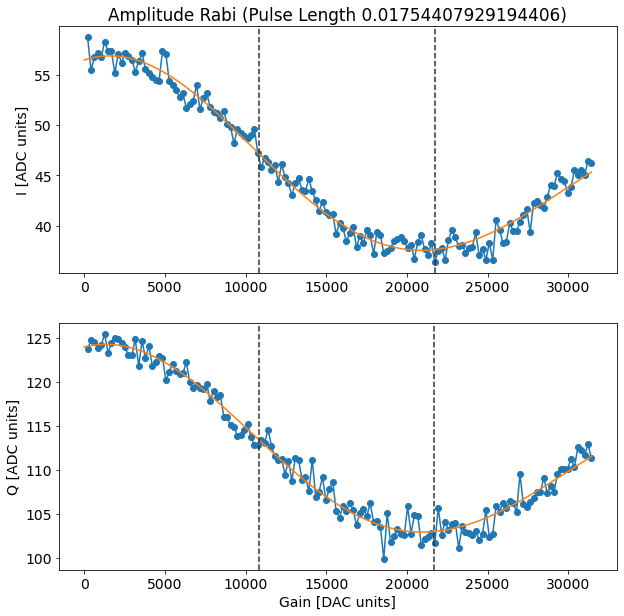

*Set Q1 pi pulse sigma with Q2 in e to 0.01754407929194406*
*Set Q1 pi pulse gain with Q2 in e to 21713*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 3.2972799999999998, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Attempted to init fitparam 1 to 7.5980799999999995, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Attempted to init fitparam 1 to 7.5980799999999995, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Current pi pulse frequency: 3462.6479880140837
Fit frequency from I [MHz]: 0.9582934264547739 +/- 0.026443230047244873
Suggested new pi pulse frequency from fit I [MHz]:
 	3462.6896945876288
 	3460.6896945876288
T2 Ramsey from fit I [us]: 2.078683035714286
Fit frequency from Q [MHz]: 0.9500538309514439 +/- 0.02201202905762231
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3462.6979341831325
 	3460.6979341831325
T2 Ramsey from fit Q [us]: 2.078683035714286


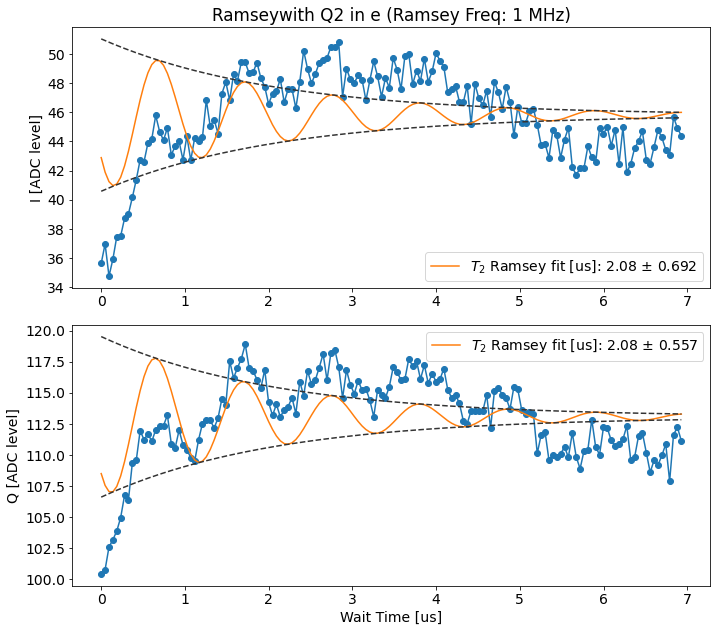

*Set Q1 pi pulse freq with Q2 in e to 3462.6979341831325*



######### BEGINNING QUBIT 3 #########
-------- length rabi --------


  0%|          | 0/101 [00:00<?, ?it/s]

Decay from avgi [us] 0.3673902580859479
Pi length from avgi data [us]: 0.01917305998140014
	Pi/2 length from avgi data [us]: 0.00958652999070007

Decay from avgq [us] 0.33874368811052474
Pi length from avgq data [us]: 0.019129309103648198
Pi/2 length from avgq data [us]: 0.009564654551824099


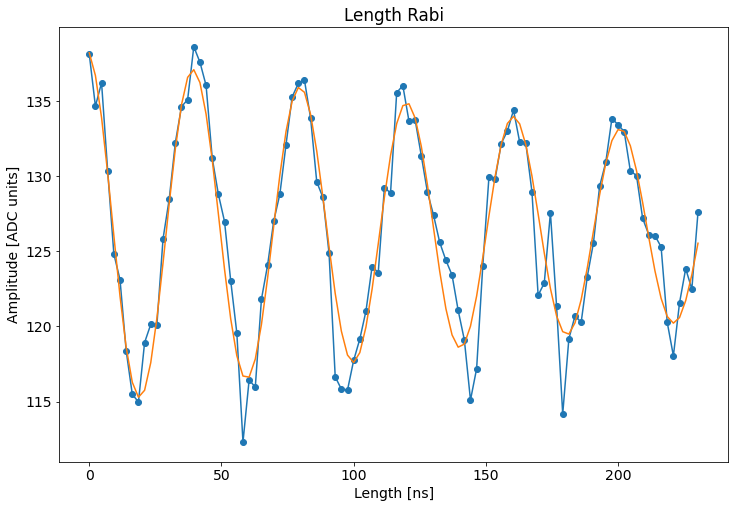

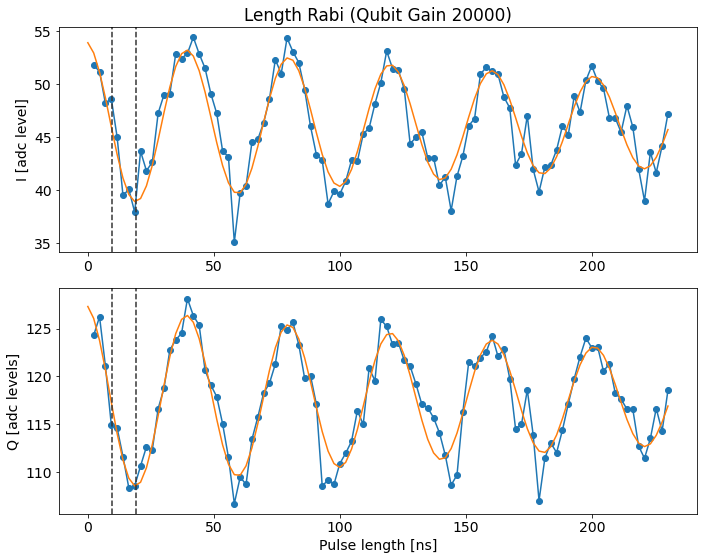

Will use sigma 0.0172305338337541 for amplitude rabi
-------- Amp rabi --------
1551544978


  0%|          | 0/30 [00:00<?, ?it/s]

19623
Attempted to init fitparam 4 to 42.21506988116217, which is out of bounds 101.18137332248884 to 128.57914965433102. Instead init to 114.88026148840993
Pi gain from avgi data [dac units]: 24537
	Pi/2 gain from avgi data [dac units]: 12268
Pi gain from avgq data [dac units]: 24952
	Pi/2 gain from avgq data [dac units]: 12476


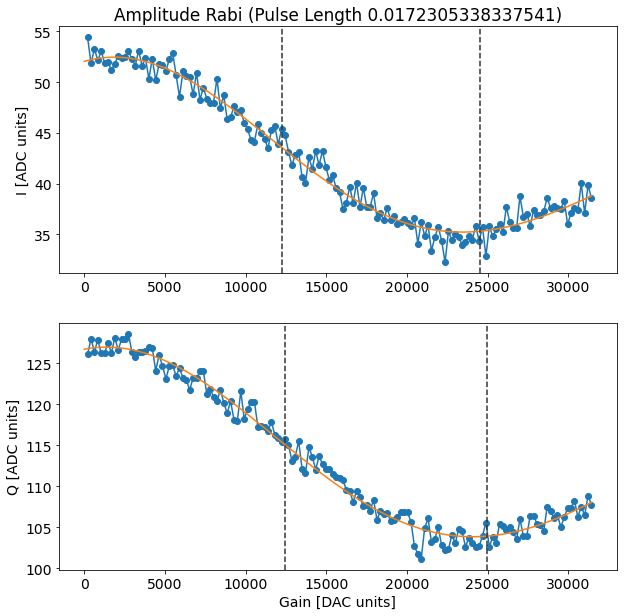

*Set Q1 pi pulse sigma with Q3 in e to 0.0172305338337541*
*Set Q1 pi pulse gain with Q3 in e to 24537*
-------- Ramsey --------


  0%|          | 0/40 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 3.5839999999999996, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Attempted to init fitparam 1 to 3.5839999999999996, which is out of bounds 0.01443221476510067 to 2.1648322147651005. Instead init to 1.0896322147651005
Current pi pulse frequency: 3462.424516152739
Fit frequency from I [MHz]: 1.7573915344132176 +/- 0.061007354482684836
Suggested new pi pulse frequency from fit I [MHz]:
 	3461.667124618326
 	3459.667124618326
T2 Ramsey from fit I [us]: 2.078683035714286
Fit frequency from Q [MHz]: 0.890242649513367 +/- 0.008008686213945768
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3462.534273503226
 	3460.534273503226
T2 Ramsey from fit Q [us]: 2.0786830357142927


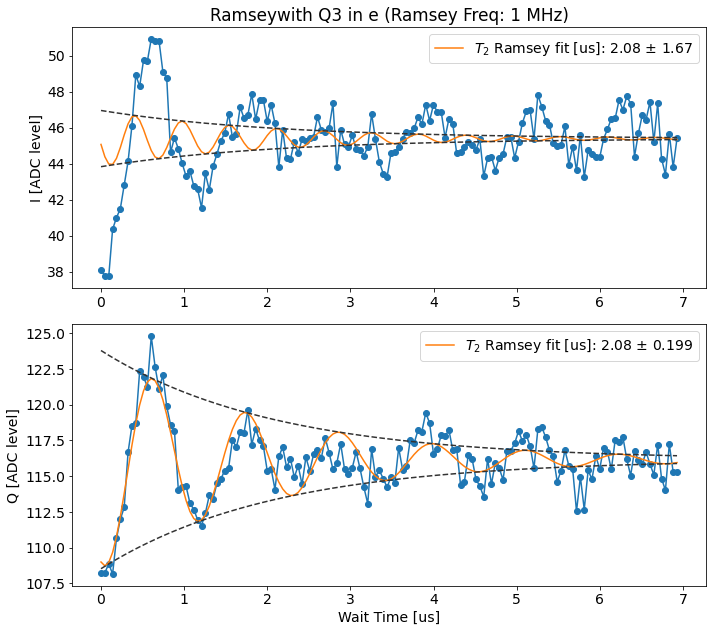

*Set Q1 pi pulse freq with Q3 in e to 3462.534273503226*





In [48]:
try: save_data
except:
    assert False, 'you did not run the cell above!'
q1 = 1
for q0 in [1, 2, 3]:
# for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=2000,
        gain=20000,
        pulse_type='gauss',
        qubits=[q0, q1],
        checkZZ=True,
        checkEF=False, 
    )

    try:
        import Pyro4.util
        try:
            lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        lengthrabiZZ.analyze(fit=True)
    
        lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
        lengthrabiZZ.display(fit=True)
        p = lengthrabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
        else: pi_len = (3/2 - p[2]/180)/2/p[1]
        pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
        lengthrabi_decay = p[3]

        print(f'Will use sigma {pi_len} for amplitude rabi')

        if save_data: saved_files.append(lengthrabiZZ.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = 32000
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=30,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(20), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=1, # [MHz]
        reps=100,
        rounds=40,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue
    
    print("\n\n")

In [49]:
print(results)
for saved_file in saved_files:
    print(saved_file)

{'gain': [21703, 0, 21713, 24537], 'sigma': [0.017758360219541528, 0, 0.01754407929194406, 0.0172305338337541], 'f_Q1_ZZ': [3458.544130078918, 0, 3462.6979341831325, 3462.534273503226]}
